In [1]:
import numpy as np
import os
import scipy.stats as sps
from scipy.interpolate import CubicSpline

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import qp


In [2]:
# Run Notebook that contains neccessary functions
%run convert_file.ipynb
%run f_nu_models.ipynb


# Constants #

In [4]:
# these things don't change the value because they get cancelled for color (only depends on SED which depends on temperature)
R = (0.185*u.Rsun).cgs.value
d = (10*u.pc).cgs.value
# F_0 in AB system, which is constant
F_0 = (3631.00*u.Jy).cgs.value



#  Color Magnitude Differences #

In [52]:
# Read in Z, Y, r, and i passband files
wavelengths_z, transmission_z = ascii_to_array('CTIO/CTIO_DECam-z.txt')
wavelengths_Y, transmission_Y = ascii_to_array('CTIO/CTIO_DECam.Y.txt')
wavelengths_i, transmission_i = ascii_to_array('CTIO/CTIO_DECam.i.txt')
wavelengths_r, transmission_r = ascii_to_array('CTIO/CTIO_DECam.r.txt')

# Get surface flux from spline
# f_nu_table = fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_3000.fits', 'g50')
f_nu_table = fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_2800.fits', 'g50')


f_nu_z = passband_flux(f_nu_table(wavelengths_z.cgs.value), transmission_z, wavelengths_z)
f_nu_Y = passband_flux(f_nu_table(wavelengths_Y.cgs.value), transmission_Y, wavelengths_Y)
f_nu_i = passband_flux(f_nu_table(wavelengths_i.cgs.value), transmission_i, wavelengths_i)
f_nu_r = passband_flux(f_nu_table(wavelengths_r.cgs.value), transmission_r, wavelengths_r)

m_z = get_and_compare_mag(f_nu_z, R, d, F_0)
m_Y = get_and_compare_mag(f_nu_Y, R, d, F_0)
m_i = get_and_compare_mag(f_nu_i, R, d, F_0)
m_r = get_and_compare_mag(f_nu_r, R, d, F_0)

print(f"r-i: {m_r - m_i}")
print(f"i-z: {m_i - m_z}")
print(f"z-Y: {m_z - m_Y}")

11.267609985771603
r-i: 2.1546643660200306
i-z: 0.9489481769004104
z-Y: 0.3411371969152057


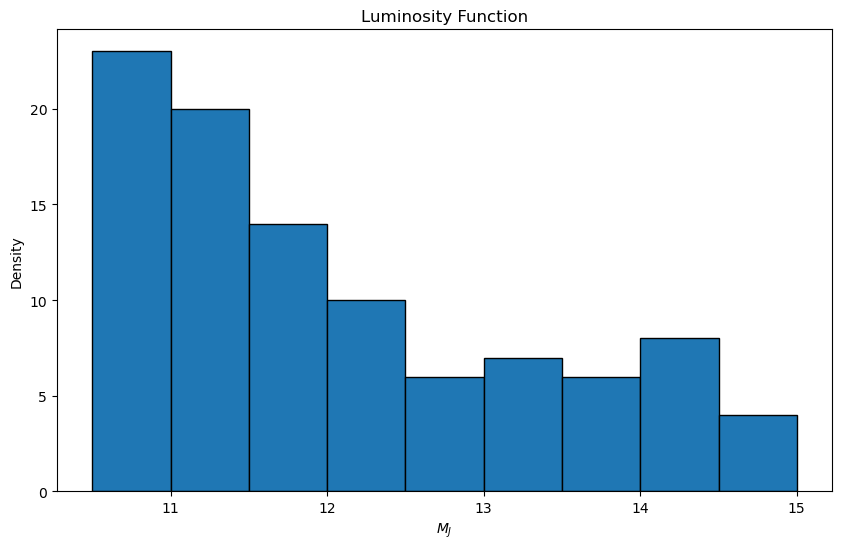

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
# Parameters
shift_amount = 10.5  # Amount to shift the distribution to the right


# Values and Frequencies
midpoints = np.array([10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75])
# midpoints rounded to M_J array from paper:
rounded_midpoints = np.array([10.47, 11.04, 12.22, 12.22, 12.22, 12.22, 12.22, 15.68, 15.68])
counts = np.array([23, 20, 14, 10, 6, 7, 6, 8, 4])

plt.bar(midpoints, counts, width=0.5, edgecolor='black')

plt.xlabel('$M_J$')
# Density
plt.ylabel('Density')
# plt.ylabel('$\Phi(M_J)$'+ '(' + '$10^{-3}$' + 'objects ' + '$pc^{-3}$' + '$mag^{-1}$' +')')
plt.title('Luminosity Function')
plt.show()


In [8]:
# Get surface flux from spline
# f_nu_table = fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_3000.fits', 'g50')
f_nu_table_2400K_g50 =  fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_2400.fits', 'g50')
f_nu_table_2200K_g50 =  fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_2200.fits', 'g50')
f_nu_table_2000K_g45 =  fits_to_spline('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/phoenix/phoenixm00/phoenixm00_2000.fits', 'g45')




# z - J #

In [10]:
f_nu_z = passband_flux(f_nu_table_2400K_g50(wavelengths_z.cgs.value), transmission_z, wavelengths_z)
m_z = get_and_compare_mag(f_nu_z, R, d, F_0)
print(f"z-J: {m_z - rounded_midpoints[0]}")

z-J: 1.6810891893035649


In [11]:
def z_J_mag(f_nu_Table, J_index, wavelengths_z=wavelengths_z, transmission_z=transmission_z, R=R, d=d, F_0=F_0):
    f_nu_z = passband_flux(f_nu_Table(wavelengths_z.cgs.value), transmission_z, wavelengths_z)
    m_z = get_and_compare_mag(f_nu_z, R, d, F_0)
    print(f"z-J: {m_z - rounded_midpoints[J_index]}")

In [12]:
z_J_mag(f_nu_table_2400K_g50, 0)
z_J_mag(f_nu_table_2200K_g50, 1)
z_J_mag(f_nu_table_2000K_g45, 2)
# z_J_mag(f_nu_table_2000K_g45, 3)
# z_J_mag(f_nu_table_2000K_g45, 4)
# z_J_mag(f_nu_table_2000K_g45, 5)
# z_J_mag(f_nu_table_2000K_g45, 6)
# z_J_mag(f_nu_table_2000K_g45, 7)
z_J_mag(f_nu_table_2000K_g45, 8)

z-J: 1.6810891893035649
z-J: 1.6917263668433637
z-J: 2.0466870427449795
z-J: -1.4133129572550196


# Function for getting difference between color magnitudes #

In [14]:

def get_color_diff(wavelengths1, wavelengths2, transmission1, transmission2, f_nu_Table, R=R, d=d, F_0=F_0):
    f_nu_1 = passband_flux(f_nu_Table(wavelengths1.cgs.value), transmission1, wavelengths1)
    f_nu_2 = passband_flux(f_nu_Table(wavelengths2.cgs.value), transmission2, wavelengths2)
    m_1 = get_and_compare_mag(f_nu_1, R, d, F_0)
    m_2 = get_and_compare_mag(f_nu_2, R, d, F_0)
    print({m_1 - m_2})

#  r - i #

In [16]:
get_color_diff(wavelengths_r, wavelengths_i, transmission_r, transmission_i, f_nu_table_2400K_g50)
get_color_diff(wavelengths_r, wavelengths_i, transmission_r, transmission_i, f_nu_table_2200K_g50)
get_color_diff(wavelengths_r, wavelengths_i, transmission_r, transmission_i, f_nu_table_2000K_g45)

{2.6632166549913308}
{2.5155935159720304}
{2.414617820726491}


# i - z #

In [18]:
get_color_diff(wavelengths_i, wavelengths_z, transmission_i, transmission_z, f_nu_table_2400K_g50)
get_color_diff(wavelengths_i, wavelengths_z, transmission_i, transmission_z, f_nu_table_2200K_g50)
get_color_diff(wavelengths_i, wavelengths_z, transmission_i, transmission_z, f_nu_table_2000K_g45)

{1.5851394358811248}
{1.8610180465419965}
{2.0821129309012}


# z - Y #

In [20]:
get_color_diff(wavelengths_z, wavelengths_Y, transmission_z, transmission_Y, f_nu_table_2400K_g50)
get_color_diff(wavelengths_z, wavelengths_Y, transmission_z, transmission_Y, f_nu_table_2200K_g50)
get_color_diff(wavelengths_z, wavelengths_Y, transmission_z, transmission_Y, f_nu_table_2000K_g45)

{0.5417119366822902}
{0.6128292647110012}
{0.7631576157843654}


# Converting from pdf to cdf with qp package #

In [22]:
sample_size = 100000
bin_edges = np.linspace(10.5, 15, 10)
counts = np.array([23, 20, 14, 10, 6, 7, 6, 8, 4])
bin_widths = 0.5
midpoints = 0.5*(bin_edges[:-1]+bin_edges[1:])
data = np.repeat(midpoints, counts)
pdfs = counts/np.sum(counts*bin_widths)

# qp.Ensemble class has objects representing a set of probability density functions
ens_h = qp.Ensemble(qp.hist, data=dict(bins=bin_edges, pdfs=pdfs))
# random_state same as previous way
seed_val = 3
rng = np.random.default_rng(seed_val)
ens_h.rvs(size=sample_size, random_state=rng)

array([[10.68246996, 11.00518574, 13.39463554, ..., 11.24815433,
        11.54787844, 12.21506381]])

# Using cubic spline to interpolate: Teff as function of M_J and log(g) as function of M_J #

CITE WEBSITE AND TABLE NO.

Text(0, 0.5, '$T_{eff} (K)$')

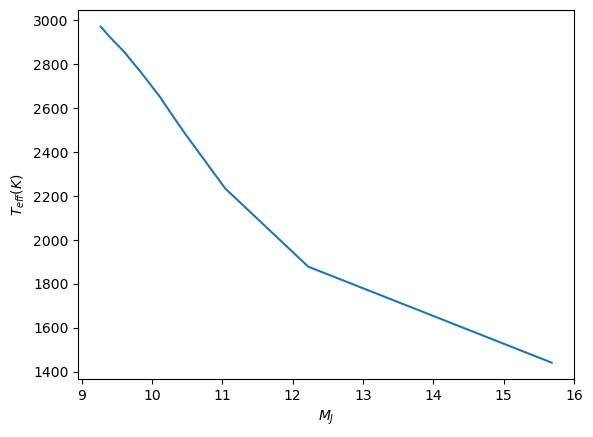

In [43]:
# 0.1 GYR
T_eff = np.array([1441, 1878, 2234, 2483, 2576, 2652, 2768, 2787, 2814, 2854, 2920, 2971])
M_J = np.array([ 15.68, 12.22, 11.04, 10.47, 10.27, 10.11, 9.83, 9.78, 9.71, 9.61, 9.41, 9.27])
log_g = np.array([4.53, 4.71, 4.80, 4.84, 4.86, 4.87, 4.88, 4.88, 4.88, 4.89, 4.89, 4.90])


sorted_indices = np.argsort(M_J)
sorted_M_J = M_J[sorted_indices]
sorted_T_eff = T_eff[sorted_indices]
sorted_log_g = log_g[sorted_indices]
cs_Teff = CubicSpline(sorted_M_J, sorted_T_eff)
cs_log_g = CubicSpline(sorted_M_J, sorted_log_g)

plt.plot(sorted_M_J, cs_Teff(sorted_M_J))
plt.xlabel(r"$M_J$")
plt.ylabel(r"$T_{eff} (K)$")

Text(0, 0.5, '$log(g)$')

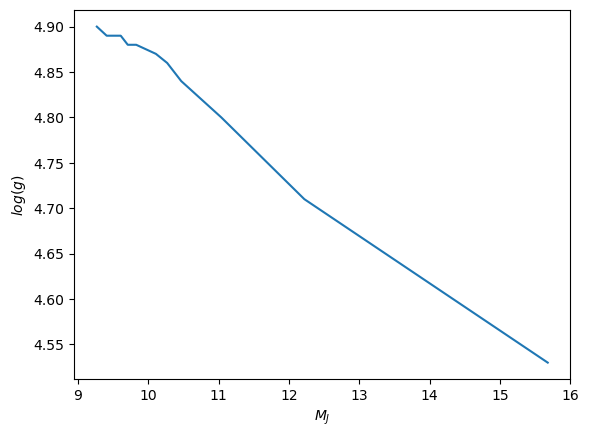

In [45]:
plt.plot(sorted_M_J, cs_log_g(sorted_M_J))
plt.xlabel(r"$M_J$")
plt.ylabel(r"$log(g)$")